In [1]:
import numpy as np 
import pandas as pd 
from data_processing import generate_vocab, process_data, create_dataloaders
from model import get_pretrained_emb, EncoderRNN, DecoderRNN, DecoderAttnRNN, EncoderDecoder, EncoderDecoderAttn
from train_eval import train_and_eval, count_parameters, summarize_results, load_experiment_log, \
    plot_single_learning_curve, plot_multiple_learning_curves
import pickle as pkl 
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# params required for generating data loaders 

SRC_LANG = 'vi'
TARG_LANG = 'en'

SRC_MAX_SENTENCE_LEN = 10
TARG_MAX_SENTENCE_LEN = 10
SRC_VOCAB_SIZE = 30000 
TARG_VOCAB_SIZE = 30000 

BATCH_SIZE = 64 

In [3]:
# takes a long time to process, save to pickle for reimport in future 
# vocab = generate_vocab(SRC_LANG, TARG_LANG, SRC_VOCAB_SIZE, TARG_VOCAB_SIZE)
# vocab_filename = "{}-{}-vocab.p".format(SRC_LANG, TARG_LANG)
# pkl.dump(vocab, open(vocab_filename, "wb"))

In [4]:
# reload from pickle 
vocab_filename = "{}-{}-vocab.p".format(SRC_LANG, TARG_LANG)
vocab = pkl.load(open(vocab_filename, "rb"))
data = process_data(SRC_LANG, TARG_LANG, SRC_MAX_SENTENCE_LEN, TARG_MAX_SENTENCE_LEN, vocab, filter_long=False)
data_minibatch = process_data(SRC_LANG, TARG_LANG, SRC_MAX_SENTENCE_LEN, TARG_MAX_SENTENCE_LEN, vocab, sample_limit=BATCH_SIZE, filter_long=False) 
data_minitrain = process_data(SRC_LANG, TARG_LANG, SRC_MAX_SENTENCE_LEN, TARG_MAX_SENTENCE_LEN, vocab, sample_limit=1000, filter_long=False)

In [5]:
# create dataloaders 
loaders_full = create_dataloaders(data, SRC_MAX_SENTENCE_LEN, TARG_MAX_SENTENCE_LEN, BATCH_SIZE)
loaders_minibatch = create_dataloaders(data_minibatch, SRC_MAX_SENTENCE_LEN, TARG_MAX_SENTENCE_LEN, BATCH_SIZE)
loaders_minitrain = create_dataloaders(data_minitrain, SRC_MAX_SENTENCE_LEN, TARG_MAX_SENTENCE_LEN, BATCH_SIZE)

In [3]:
# model architecture params 
NETWORK_TYPE = 'rnn'
RNN_CELL_TYPE = 'gru'
NUM_LAYERS = 2 
ENC_HIDDEN_DIM = 512
DEC_HIDDEN_DIM = 2 * ENC_HIDDEN_DIM 
TEACHER_FORCING_RATIO = 1
CLIP_GRAD_MAX_NORM = 1
ENC_DROPOUT = 0.2 
DEC_DROPOUT = 0.2 
ATTENTION_TYPE = 'additive'

# training params  
NUM_EPOCHS = 5
LR = 0.0003 # 0.0005
OPTIMIZER = 'Adam'
LAZY_TRAIN = False

# name the model and experiment 
EXPERIMENT_NAME = 'hyperparameter_tuning_dropout'
if NETWORK_TYPE == 'rnn': 
    MODEL_NAME = '{}-rnn-{}-attn'.format(SRC_LANG, ATTENTION_TYPE)
elif NETWORK_TYPE == 'cnn': 
    MODEL_NAME = '{}-cnn'.format(SRC_LANG)

In [4]:
# store as dict to save to results later 
params = {'experiment_name': EXPERIMENT_NAME,'model_name': MODEL_NAME, 'src_lang': SRC_LANG, 'targ_lang': TARG_LANG, 
          'rnn_cell_type': RNN_CELL_TYPE, 'src_max_sentence_len': SRC_MAX_SENTENCE_LEN, 
          'targ_max_sentence_len': TARG_MAX_SENTENCE_LEN, 'src_vocab_size': SRC_VOCAB_SIZE, 
          'targ_vocab_size': TARG_VOCAB_SIZE, 'num_layers': NUM_LAYERS, 'enc_hidden_dim': ENC_HIDDEN_DIM, 
          'dec_hidden_dim': DEC_HIDDEN_DIM, 'teacher_forcing_ratio': TEACHER_FORCING_RATIO, 
          'clip_grad_max_norm': CLIP_GRAD_MAX_NORM, 'enc_dropout': ENC_DROPOUT, 'dec_dropout': DEC_DROPOUT, 
          'attention_type': ATTENTION_TYPE, 'batch_size': BATCH_SIZE, 'num_epochs': NUM_EPOCHS, 
          'learning_rate': LR, 'optimizer': OPTIMIZER, 'lazy_train': LAZY_TRAIN} 

In [8]:
for candidate in [0, 0.2, 0.5]: 
    
    print("Training with dropout = {}".format(candidate))
    
    # overwrite relevant key-value in params 
    params['enc_dropout'] = candidate 
    params['dec_dropout'] = candidate
    params['model_name'] = '{}-rnn-{}-attn-{}-dropout'.format(SRC_LANG, ATTENTION_TYPE, candidate)
    
    # instantiate model 
    encoder = EncoderRNN(rnn_cell_type=RNN_CELL_TYPE, enc_hidden_dim=ENC_HIDDEN_DIM, num_layers=NUM_LAYERS, 
                         src_max_sentence_len=SRC_MAX_SENTENCE_LEN, enc_dropout=candidate, 
                         pretrained_word2vec=get_pretrained_emb(vocab[SRC_LANG]['word2vec'], vocab[SRC_LANG]['token2id']))
    decoder = DecoderAttnRNN(rnn_cell_type=RNN_CELL_TYPE, dec_hidden_dim=DEC_HIDDEN_DIM, enc_hidden_dim=ENC_HIDDEN_DIM, 
                             num_layers=NUM_LAYERS, targ_vocab_size=TARG_VOCAB_SIZE, 
                             src_max_sentence_len=SRC_MAX_SENTENCE_LEN, targ_max_sentence_len=TARG_MAX_SENTENCE_LEN, 
                             dec_dropout=candidate, attention_type=ATTENTION_TYPE,
                             pretrained_word2vec=get_pretrained_emb(vocab[TARG_LANG]['word2vec'], 
                                                                    vocab[TARG_LANG]['token2id']))
    model = EncoderDecoderAttn(encoder, decoder, vocab[TARG_LANG]['token2id']).to(device) 
    
    # train and eval 
    model, results = train_and_eval(
        model=model, loaders_full=loaders_full, loaders_minibatch=loaders_minibatch, loaders_minitrain=loaders_minitrain, 
        params=params, vocab=vocab, print_intermediate=500, save_checkpoint=True, save_to_log=True, 
        lazy_eval=True, print_attn=False, inspect_samples=3)

Training with dropout = 0
Epoch: 0.00, Train Loss: 0.00, Val Loss: 10.24, Train BLEU: 0.00, Val BLEU: 0.07, Minutes Elapsed: 0.09
Sampling from val predictions...
Source: và bắt_đầu học để chuẩn_bị cho kì thi đại_học .
Reference: i started studying for the university entrance exam .
Model: <SOS> and and the the the the the the the

Source: tôi vừa_mới thay_đổi hoàn_toàn những gì bạn nghĩ về tôi
Reference: i just totally transformed what you thought of me
Model: <SOS> and and the the the the the the the

Source: như các bạn thấy đó , các bóng_đèn hướng ra
Reference: as you can see , the bulbs face outside
Model: <SOS> and and the the the the the the the



Epoch: 0.24, Train Loss: 0.00, Val Loss: 5.98, Train BLEU: 0.00, Val BLEU: 2.20, Minutes Elapsed: 8.25
Sampling from val predictions...
Source: có_thể sự thiếu_sót không chỉ là về mặt bình_quyền của
Reference: maybe what was missing was not the women only
Model: <SOS> so is a a a a a a a

Source: đây là nơi người dân bàn_giao chúng , và hôm
Reference: this is where people were handing them in ,
Model: <SOS> it &apos;s , , , , , , ,

Source: những gì chúng_tôi có_thể làm là dùng miếng bùi_nhùi bằng
Reference: so what we can do is use steel wool
Model: <SOS> but we a a a a a a to



Epoch: 0.48, Train Loss: 0.00, Val Loss: 5.32, Train BLEU: 0.00, Val BLEU: 4.96, Minutes Elapsed: 16.47
Sampling from val predictions...
Source: " tôi không giúp_đỡ cô , " ông ta trả_lời
Reference: &quot; i &apos;m not helping you , &quot; he
Model: <SOS> &quot; said i , , &quot; , , ,

Source: công_ty nhỏ nhất , công_ty lớn nhất , phải có
Reference: the smallest company , the biggest company , has
Model: <SOS> we we , , , we , , ,

Source: làm_sao chúng_ta có_thể tạo ra_điều quỷ_quyệt này , lại còn
Reference: how can we affect something so insidious , yet
Model: <SOS> we we can can to the the , ,



Epoch: 0.72, Train Loss: 0.00, Val Loss: 4.96, Train BLEU: 0.00, Val BLEU: 8.13, Minutes Elapsed: 24.75
Sampling from val predictions...
Source: có một người phụ_nữ địa_phương tuyệt_vời đã hướng_dẫn chúng_tôi .
Reference: we had an amazing local woman who guided us
Model: <SOS> there &apos;s a a of that . . .

Source: vì_thế tôi phải tìm_ra cách để giải_quyết vấn_đề này .
Reference: so i had to find a way of solving
Model: <SOS> so i &apos;m to to to to to to

Source: làm thế_nào chúng_ta cho_mượn và mượn nhiều thứ hơn mà
Reference: how can we lend and borrow more things without
Model: <SOS> so , we and and and and the to



Epoch: 0.96, Train Loss: 0.00, Val Loss: 4.73, Train BLEU: 0.00, Val BLEU: 8.62, Minutes Elapsed: 33.06
Sampling from val predictions...
Source: chúng_ta không đụng vào mỗi người xung_quanh , vì_vậy có
Reference: we don &apos;t bump into every neighbor , so
Model: <SOS> we don &apos;t have to the , , ,

Source: ông_ngoại của tôi là một người thật đáng khâm_phục vào
Reference: my grandfather was an extraordinary man for his time
Model: <SOS> my my is a a of that the .

Source: không bao_giờ có từ " tôi , và từ "
Reference: never the word &quot; i , &quot; and the
Model: <SOS> it &apos;t &apos;t , from , from &quot; ,



Epoch: 1.00, Train Loss: 0.00, Val Loss: 4.74, Train BLEU: 0.00, Val BLEU: 8.81, Minutes Elapsed: 34.51
Sampling from val predictions...
Source: bạn có_thể thấy được những phần trọng_yếu nhất , giống
Reference: you can see the hubs , like who are
Model: <SOS> you can see the the of the , ,

Source: không có đạo_diễn nghệ_thuật , không có nhà tạo mẫu
Reference: there were no art directors , no <UNK> ,
Model: <SOS> there &apos;s no , , no no no no

Source: nó là vật_liệu gây ồn , nếu chúng_ta làm những
Reference: it &apos;s a noisy material , and if we
Model: <SOS> it &apos;s a a , , if we we



Epoch: 1.24, Train Loss: 0.00, Val Loss: 4.58, Train BLEU: 0.00, Val BLEU: 10.92, Minutes Elapsed: 42.75
Sampling from val predictions...
Source: nó xảy_ra mọi nơi . <EOS> <PAD> <PAD> <PAD> <PAD>
Reference: it &apos;s everywhere . <EOS> <PAD> <PAD> <PAD> <PAD>
Model: <SOS> it &apos;s happen . <EOS> . . <EOS> <EOS>

Source: đôi_khi chúng tạo nên các ổ gà . <EOS> <PAD>
Reference: sometimes you can create potholes with that . <EOS>
Model: <SOS> sometimes they they to to . <EOS> . <EOS>

Source: tôi chẳng cho họ tiền được , không gì cả
Reference: i couldn &apos;t give them money , nothing .
Model: <SOS> i &apos;m them them them , , , it



Epoch: 1.48, Train Loss: 0.00, Val Loss: 4.45, Train BLEU: 0.00, Val BLEU: 11.12, Minutes Elapsed: 51.11
Sampling from val predictions...
Source: hỡi các nhà khoa_học và kỹ_sư , hãy tám <UNK>
Reference: so scientists and engineers , please , talk nerdy
Model: <SOS> so , and and , you went to <UNK>

Source: chúng_tôi đã có khoảng 50 người tới tham_gia đào_bới ,
Reference: we &apos;ve had , like , 50 people come
Model: <SOS> we had been 50 percent 200 people people to

Source: chúng_tôi không có bất_cứ cơ_sở_hạ_tầng nào . <EOS> <PAD> <PAD>
Reference: we have zero infrastructure . <EOS> <PAD> <PAD> <PAD>
Model: <SOS> we have no have . <EOS> . <EOS> <EOS>



Epoch: 1.72, Train Loss: 0.00, Val Loss: 4.33, Train BLEU: 0.00, Val BLEU: 12.12, Minutes Elapsed: 59.51
Sampling from val predictions...
Source: từ khi còn nhỏ , tôi đã từng làm_việc ở
Reference: since i was a small boy , i used
Model: <SOS> since i i a , , , i was

Source: bạn thậm_chí có thể biết được tôi tới <UNK> bằng
Reference: and you can even see how i go from
Model: <SOS> you can can have know know i i to

Source: nhưng bạn có_thể thấy cách mà chúng_ta giao_tiếp với nhau
Reference: but you can see how your people are communicating
Model: <SOS> but you can see how that we is different



Epoch: 1.96, Train Loss: 0.00, Val Loss: 4.26, Train BLEU: 0.00, Val BLEU: 12.62, Minutes Elapsed: 67.90
Sampling from val predictions...
Source: nếu nhiếp_ảnh_gia đứng ở đây còn ánh_sáng thì ở kia
Reference: so if the photographer is right there and the
Model: <SOS> if you have have is there there there the

Source: tôi đã rất <UNK> . <EOS> <PAD> <PAD> <PAD> <PAD>
Reference: and i was distraught . <EOS> <PAD> <PAD> <PAD>
Model: <SOS> i &apos;ve &apos;m very . <EOS> . a <EOS>

Source: tôi đã rất sợ . <EOS> <PAD> <PAD> <PAD> <PAD>
Reference: and i was scared . <EOS> <PAD> <PAD> <PAD>
Model: <SOS> i was &apos;m very . <EOS> . a <EOS>



Epoch: 2.00, Train Loss: 0.00, Val Loss: 4.29, Train BLEU: 0.00, Val BLEU: 12.32, Minutes Elapsed: 69.34
Sampling from val predictions...
Source: nó là thông_tin về tất_cả chúng_ta . <EOS> <PAD> <PAD>
Reference: it &apos;s about all of us . <EOS> <PAD>
Model: <SOS> it &apos;s the the of of of all all

Source: cậu_bé khiếp_đảm vì sợ rơi xuống_nước . <EOS> <PAD> <PAD>
Reference: he was petrified he would be knocked in the
Model: <SOS> he was because by the the the in the

Source: trong_suốt bốn thập_kỉ , nền chuyên_chế tàn_bạo của gaddafi đã
Reference: for four decades gaddafi &apos;s tyrannical regime destroyed the
Model: <SOS> in the , , the the , the the



Epoch: 2.24, Train Loss: 0.00, Val Loss: 4.23, Train BLEU: 0.00, Val BLEU: 13.47, Minutes Elapsed: 77.63
Sampling from val predictions...
Source: sau cuộc nói_chuyện , tôi thấy thật kinh_khủng và thực_sự
Reference: after we finished talking , i felt so horrible
Model: <SOS> after i i , i i was really and

Source: khi tôi 11 tuổi , tôi nhớ một buổi sáng
Reference: when i was 11 , i remember waking up
Model: <SOS> when i was , , i was a a

Source: sau sáu tháng tại nhật bản , 1.100 tình_nguyện viên
Reference: after six months in japan , 1,100 volunteers had
Model: <SOS> after the months , , , , , of



Epoch: 2.48, Train Loss: 0.00, Val Loss: 4.17, Train BLEU: 0.00, Val BLEU: 13.79, Minutes Elapsed: 85.97
Sampling from val predictions...
Source: nhìn qua , công_trường đập đá có_vẻ đầy những người
Reference: at first glance , the pounding site seems full
Model: <SOS> look , , , the &apos;s of , seem

Source: sao_vậy ? bởi_vì họ nhìn vào đường_cong trên phác_đồ và
Reference: why ? because they looked at the curve and
Model: <SOS> why ? because they look at the future ,

Source: nhưng những người bắc triều_tiên này thì không được may_mắn
Reference: these north koreans were not so lucky . <EOS>
Model: <SOS> but these people who not not . . .



Epoch: 2.72, Train Loss: 0.00, Val Loss: 4.11, Train BLEU: 0.00, Val BLEU: 14.03, Minutes Elapsed: 94.31
Sampling from val predictions...
Source: khi tôi gặp , anh ta đã làm việc 14
Reference: when i met him , he had been working
Model: <SOS> when i was , he he was a a

Source: như các bạn có_thể thấy , tấm pin mặt_trời dùng
Reference: as you can see , the solar panel charges
Model: <SOS> as you can see , the car of ,

Source: giống_như ba_lê nó cần được đào_tạo đặc_biệt . <EOS> <PAD>
Reference: and like ballet , it takes an extraordinary level
Model: <SOS> now , , it needed &apos;s to . .



Epoch: 2.96, Train Loss: 0.00, Val Loss: 4.09, Train BLEU: 0.00, Val BLEU: 14.00, Minutes Elapsed: 102.66
Sampling from val predictions...
Source: đó là một làng chài nhỏ thuộc tỉnh <UNK> ,
Reference: it &apos;s a small fishing town in <UNK> <UNK>
Model: <SOS> it &apos;s a <UNK> <UNK> of <UNK> <UNK> ,

Source: lò vi_sóng cũng có hệ_thống hoạt_động tương_tự . <EOS> <PAD>
Reference: so a microwave is a similar system . <EOS>
Model: <SOS> there &apos;s has has has a system . <EOS>

Source: nhân_vật này chưa bao_giờ được sinh ra . <EOS> <PAD>
Reference: this person has never been born . <EOS> <PAD>
Model: <SOS> this this never never born . . <EOS> <EOS>



Epoch: 3.00, Train Loss: 0.00, Val Loss: 4.13, Train BLEU: 0.00, Val BLEU: 13.39, Minutes Elapsed: 104.11
Sampling from val predictions...
Source: ý_tưởng đầu_tiên mà tôi có được là sử_dụng lửa ,
Reference: and the first idea i got was to use
Model: <SOS> the first first idea that i had a ,

Source: chúng_tôi cần bắt_đầu hành_động như những sứ giả_của lòng trắc_ẩn
Reference: we need to start acting as agents of compassion
Model: <SOS> we need to start to like like of the

Source: nhưng thật nản_lòng là với bệnh parkinson và các chứng
Reference: but <UNK> , with parkinson &apos;s disease and other
Model: <SOS> but it &apos;s also &apos;s , the and and



Epoch: 3.24, Train Loss: 0.00, Val Loss: 4.10, Train BLEU: 0.00, Val BLEU: 14.10, Minutes Elapsed: 112.44
Sampling from val predictions...
Source: hôm_nay tôi dùng một lò vi_sóng vì tôi không_thể đem
Reference: today i use a microwave because i cannot take
Model: <SOS> i i i a a for i i &apos;t

Source: làm_sao họ có_thể không đồng_tình chứ ? <EOS> <PAD> <PAD>
Reference: why in the hell would they not okay this
Model: <SOS> how can they can can they not ? ?

Source: chúng_tôi chỉnh cho người gầy gầy hơn , da đẹp
Reference: we make skinny models <UNK> , perfect skin more
Model: <SOS> we decided the people , the , &apos;s ,



Epoch: 3.48, Train Loss: 0.00, Val Loss: 4.06, Train BLEU: 0.00, Val BLEU: 14.34, Minutes Elapsed: 120.79
Sampling from val predictions...
Source: tôi không phải công_dân nước đó . <EOS> <PAD> <PAD>
Reference: i wasn &apos;t a citizen of that country .
Model: <SOS> i was not that agree of . . <EOS>

Source: nhưng vẫn hi_vọng ngày nào đó có_thể rời_khỏi căn_nhà này
Reference: &quot; we hope still , though , that we
Model: <SOS> but still , , that can can can can

Source: hàng năm , có vô_số người bắc triều_tiên bị bắt
Reference: every year , countless north koreans are caught in
Model: <SOS> for , , , were people first been first



Epoch: 3.72, Train Loss: 0.00, Val Loss: 4.05, Train BLEU: 0.00, Val BLEU: 15.71, Minutes Elapsed: 129.09
Sampling from val predictions...
Source: " trước_khi tôi chết , tôi muốn thử <UNK> .
Reference: &quot; before i die , i want to be
Model: <SOS> &quot; before i , , , i to .

Source: bạn có_thể thấy được những phần trọng_yếu nhất , giống
Reference: you can see the hubs , like who are
Model: <SOS> you can see the most of the , ,

Source: họ biết hình của họ sẽ được xem bởi những
Reference: they knew their image would be seen by you
Model: <SOS> they know their their of they at by the



Epoch: 3.96, Train Loss: 0.00, Val Loss: 4.05, Train BLEU: 0.00, Val BLEU: 14.32, Minutes Elapsed: 137.38
Sampling from val predictions...
Source: hiện_nay ý_tưởng của tôi đã được sử_dụng trên khắp kenya
Reference: and my idea is also being used now all
Model: <SOS> now my idea has been used in in kenya

Source: nhưng một thứ sẽ mãi_mãi tồn_tại với con là thứ
Reference: but the one thing that will always remain with
Model: <SOS> but one thing thing is to to to is

Source: bởi_vì bước cuối_cùng trong kịch_bản bạo_hành gia_đình là giết chết
Reference: because the final step in the domestic violence pattern
Model: <SOS> because the the last in the family , ,



Epoch: 4.00, Train Loss: 0.00, Val Loss: 4.08, Train BLEU: 0.00, Val BLEU: 13.64, Minutes Elapsed: 138.82
Sampling from val predictions...
Source: nơi đây em đang tắm ở giếng , dội những
Reference: here he &apos;s seen taking a bath at the
Model: <SOS> now here the the in the , , ,

Source: chỉ có một điều mà tất_cả mọi công_ty thành_công trên
Reference: there &apos;s only one thing that all the successful
Model: <SOS> there &apos;s just a that that the in the

Source: tôi luôn sống trong một nỗi sợ thường_trực rằng danh_tính
Reference: so i was living in constant fear that my
Model: <SOS> i always live in in a a that the



Epoch: 4.24, Train Loss: 0.00, Val Loss: 4.10, Train BLEU: 0.00, Val BLEU: 13.93, Minutes Elapsed: 147.07
Sampling from val predictions...
Source: thật đáng_tiếc sau khi bạn_học xong , bạn viết <UNK>
Reference: unfortunately after you &apos;ve gone to school , and
Model: <SOS> it &apos;s the next , , , , ,

Source: đó có nghĩa_là nó có_thể tự thực_hiện được . <EOS>
Reference: that means they can be <UNK> . <EOS> <PAD>
Model: <SOS> that means that it be it . <EOS> .

Source: ở cuối đường , anh ta giục chúng_tôi rời xe
Reference: at the end of the road , he urged
Model: <SOS> in the end , the , , he gave



Epoch: 4.48, Train Loss: 0.00, Val Loss: 4.05, Train BLEU: 0.00, Val BLEU: 14.35, Minutes Elapsed: 155.43
Sampling from val predictions...
Source: bà nghỉ_hưu 2 năm về trước để dùng nhà của
Reference: she retired two years ago , only to turn
Model: <SOS> she , about about to to the the the

Source: hôm_nay tôi 22 tuổi . <EOS> <PAD> <PAD> <PAD> <PAD>
Reference: today i am 22 . <EOS> <PAD> <PAD> <PAD>
Model: <SOS> today 22 22 22 22 old . <EOS> <EOS>

Source: vì_vậy , để thực_hiện các bước đầu_tiên hướng tới việc
Reference: so , taking the first steps towards this today
Model: <SOS> so , to all first of of the the



Epoch: 4.72, Train Loss: 0.00, Val Loss: 4.07, Train BLEU: 0.00, Val BLEU: 16.06, Minutes Elapsed: 163.76
Sampling from val predictions...
Source: cùng nhau , chúng_ta đã chỉ ra những không_gian công_cộng
Reference: together , we &apos;ve shown how powerful our public
Model: <SOS> together , we &apos;ve just a space space .

Source: tại_sao người phụ_nữ lại nên ở_lại với người đã đánh
Reference: why would anyone stay with a man who beats
Model: <SOS> why do women women to the people who the

Source: triệu chứng_bệnh ở mỗi cá_nhân một khác , đó là
Reference: it manifests in each individual differently , hence why
Model: <SOS> every the in a other , , which is



Epoch: 4.96, Train Loss: 0.00, Val Loss: 4.07, Train BLEU: 0.00, Val BLEU: 14.85, Minutes Elapsed: 172.05
Sampling from val predictions...
Source: gần hai năm đã trôi_qua từ khi cuộc khởi_nghĩa ở
Reference: almost two years have passed since the libyan revolution
Model: <SOS> over two years years have through the the of

Source: hãy tìm đọc cuốn sách của bà ấy . <EOS>
Reference: just go and read her book . <EOS> <PAD>
Model: <SOS> take read read read book book . <EOS> <EOS>

Source: tôi bây_giờ đã nhận thấy về afghanistan , và đây
Reference: what i &apos;ve come to realize about afghanistan ,
Model: <SOS> i &apos;ve &apos;ve to seen in in , ,



Epoch: 5.00, Train Loss: 0.00, Val Loss: 4.11, Train BLEU: 0.00, Val BLEU: 14.27, Minutes Elapsed: 173.46
Sampling from val predictions...
Source: bạn muốn đọc cuốn sách nào đó , hãy đọc
Reference: you want to read the book , read &quot;
Model: <SOS> you want to read that book , that read

Source: nơi đây cũng là nơi mà trung_tâm di_tản đã thu_thập
Reference: this happened to also be a place in the
Model: <SOS> now is where where where where the where the

Source: cơ_hội cho sự vĩ_đại , tiến_bộ và cho sự thay_đổi
Reference: the chance for greatness , for progress and for
Model: <SOS> opportunity miracles of the , and and and and

Model training completed in 173 minutes with 4.05 best validation loss and 16.06 best validation BLEU.
Training with dropout = 0.2
Epoch: 0.00, Train Loss: 0.00, Val Loss: 10.24, Train BLEU: 0.00, Val BLEU: 0.03, Minutes Elapsed: 0.09
Sampling from val predictions...
Source: thật đáng_buồn , rối_loạn thần_kinh như bệnh parkinson dần_dần phá_huỷ
Reference: now 

Epoch: 0.24, Train Loss: 0.00, Val Loss: 5.99, Train BLEU: 0.00, Val BLEU: 2.59, Minutes Elapsed: 8.36
Sampling from val predictions...
Source: tôi chỉ 22 tuổi , sống ở nước mỹ ,
Reference: i was 22 , and in the united states
Model: <SOS> i , , , , , , , ,

Source: tôi muốn trồng cả một mảnh vườn mà ở đó
Reference: i want to plant a whole block of gardens
Model: <SOS> i i a a a a to to ,

Source: nhựa_đường xốp là vật_liệu chúng_tôi hiện đang dùng để xây_dựng
Reference: porous asphalt , a material that we use now
Model: <SOS> but we a to to to to to to



Epoch: 0.48, Train Loss: 0.00, Val Loss: 5.34, Train BLEU: 0.00, Val BLEU: 4.48, Minutes Elapsed: 16.69
Sampling from val predictions...
Source: lòng tốt từ người đàn_ông xa_lạ trở_thành biểu_tượng hy_vọng mới
Reference: the kind stranger symbolized new hope for me and
Model: <SOS> the are of the the of , the ,

Source: hôm_nay tôi 22 tuổi . <EOS> <PAD> <PAD> <PAD> <PAD>
Reference: today i am 22 . <EOS> <PAD> <PAD> <PAD>
Model: <SOS> so i was the . <EOS> <EOS> . .

Source: nếu người đó không muốn làm , vậy_thì bạn phải
Reference: if that person doesn &apos;t want to do it
Model: <SOS> if you you you , you , you you



Epoch: 0.72, Train Loss: 0.00, Val Loss: 4.99, Train BLEU: 0.00, Val BLEU: 7.58, Minutes Elapsed: 25.06
Sampling from val predictions...
Source: chào . xin cảm_ơn . <EOS> <PAD> <PAD> <PAD> <PAD>
Reference: peace . thank you . <EOS> <PAD> <PAD> <PAD>
Model: <SOS> thank . . you . <EOS> <EOS> . <EOS>

Source: đối_với một_số người , họ đã được kết_nối với một
Reference: for some of them , it &apos;s given them
Model: <SOS> in the , , , they they a a

Source: tôi muốn giới_thiệu kofi với bạn . <EOS> <PAD> <PAD>
Reference: i want to introduce you to kofi . <EOS>
Model: <SOS> i want to to to . . . <EOS>



Epoch: 0.96, Train Loss: 0.00, Val Loss: 4.75, Train BLEU: 0.00, Val BLEU: 8.51, Minutes Elapsed: 33.43
Sampling from val predictions...
Source: thì có_lẽ <UNK> sẽ_biết những_ai đã tham_gia trong cuộc biểu_tình
Reference: and the <UNK> would have known who took part
Model: <SOS> it &apos;s , , in in in in in

Source: chi_phí cực thấp , và chúng_ta đều biết điều gì
Reference: they &apos;re ultra-low cost , and we all know
Model: <SOS> the , , , and and we we to

Source: ví_dụ , tỉ_lệ béo_phì ở vùng tôi ở cao gấp
Reference: for instance , the obesity rate in my neighborhood
Model: <SOS> for example , , &apos;s in in in in



Epoch: 1.00, Train Loss: 0.00, Val Loss: 4.75, Train BLEU: 0.00, Val BLEU: 8.33, Minutes Elapsed: 34.89
Sampling from val predictions...
Source: bấy_giờ , điều cuối_cùng tôi muốn làm là rời_bỏ new_york
Reference: now , the last thing i wanted to do
Model: <SOS> now , i i i i want to do

Source: nó trở_nên thật thiêng_liêng với chúng_tôi . <EOS> <PAD> <PAD>
Reference: it &apos;s really become sacred to us . <EOS>
Model: <SOS> it &apos;s us to our our our . <EOS>

Source: bạn nên nhìn vào cái thứ vớ_vẩn - - -
Reference: you should see the rubbish — -- you should
Model: <SOS> you you at at the -- -- -- &apos;s



Epoch: 1.24, Train Loss: 0.00, Val Loss: 4.61, Train BLEU: 0.00, Val BLEU: 10.13, Minutes Elapsed: 43.23
Sampling from val predictions...
Source: tôi không biết phải trông_đợi điều gì từ cuộc thử_nghiệm
Reference: i didn &apos;t know what to expect from this
Model: <SOS> i don &apos;t know how the this from from

Source: hai điều quan_trọng nhất chúng_ta có là thời_gian và mối
Reference: two of the most valuable things we have are
Model: <SOS> the the the things that we we have have

Source: và cũng với một chiếc điện_thoại bạn có_thể ghi_âm một
Reference: and with a mobile phone , you can record
Model: <SOS> and so a a of can can can a



Epoch: 1.48, Train Loss: 0.00, Val Loss: 4.48, Train BLEU: 0.00, Val BLEU: 11.12, Minutes Elapsed: 51.61
Sampling from val predictions...
Source: và nếu bạn sử_dụng điện_thoại_di_động , thì đây chính là
Reference: and if you use your mobile phone , where
Model: <SOS> and if you &apos;re , , , , this

Source: chúng_tôi có_thể thực_hiện sự quan_sát với tần_số cao để có
Reference: we can do <UNK> monitoring to get objective data
Model: <SOS> we can actually the to to to to to

Source: xin đừng nói với tôi rằng tôi bình_thường . <EOS>
Reference: please don &apos;t tell me i &apos;m normal .
Model: <SOS> now me me me me i i . .



Epoch: 1.72, Train Loss: 0.00, Val Loss: 4.36, Train BLEU: 0.00, Val BLEU: 11.55, Minutes Elapsed: 60.01
Sampling from val predictions...
Source: nhưng chúng có_thể làm_hư cửa_kính xe_hơi của bạn . vì_vậy
Reference: but they can damage your windshield , so you
Model: <SOS> but they can do the your . the you

Source: bí_mật đó là , cây súng này được nạp sẵn
Reference: my secret was that i had this gun loaded
Model: <SOS> so that , , , this is a .

Source: lần đầu_tiên tôi có căn_hộ , thẻ tín_dụng american express
Reference: i had my first apartment , my first little
Model: <SOS> i first first first , , the the ,



Epoch: 1.96, Train Loss: 0.00, Val Loss: 4.28, Train BLEU: 0.00, Val BLEU: 12.38, Minutes Elapsed: 68.41
Sampling from val predictions...
Source: em biết không ? em có_thể trở_thành bất_cứ ai .
Reference: you know ? you can be anything . <EOS>
Model: <SOS> you know , you can give you ? <EOS>

Source: khi tôi nhìn qua các bức ảnh , có một_số
Reference: as i looked through the photos , there were
Model: <SOS> when i look at the pictures , , &apos;s

Source: trong_khi tôi rất may_mắn vì đã được thả ra thì
Reference: even though i was really fortunate to get out
Model: <SOS> while i was i surprised surprised because because that



Epoch: 2.00, Train Loss: 0.00, Val Loss: 4.31, Train BLEU: 0.00, Val BLEU: 11.38, Minutes Elapsed: 69.88
Sampling from val predictions...
Source: nó bắt_đầu đục_khoét tâm_can , nên vài tuần sau ,
Reference: it started burning a hole in my stomach ,
Model: <SOS> it &apos;s the the , , , , ,

Source: thật_ra tôi trở_thành người_mẫu bởi_vì tôi thắng giải xổ_số di_truyền
Reference: the real way that i became a model is
Model: <SOS> i i i i i i my because because

Source: chúng_tôi cần dừng việc hành_động như những sứ_giả cuồng_nộ ,
Reference: we need to stop acting as agents of rage
Model: <SOS> we need to to the the the , the



Epoch: 2.24, Train Loss: 0.00, Val Loss: 4.24, Train BLEU: 0.00, Val BLEU: 12.95, Minutes Elapsed: 78.21
Sampling from val predictions...
Source: chúng_ta yêu_thích những vũ_công bậc_thầy về ba_lê và nhảy gõ
Reference: we delight at ballet <UNK> and tap dancers you
Model: <SOS> we we the the and the and and the

Source: đây là một trong những kế_hoạch của tôi . đây
Reference: now this is one of my plans . this
Model: <SOS> this is is one of my favorites . this

Source: " bây_giờ con có_thể thật_sự đến trường rồi " ông
Reference: &quot; you can go to a real school now
Model: <SOS> &quot; &quot; can be to &quot; &quot; &quot; &quot;



Epoch: 2.48, Train Loss: 0.00, Val Loss: 4.18, Train BLEU: 0.00, Val BLEU: 13.14, Minutes Elapsed: 86.57
Sampling from val predictions...
Source: anh ta đã làm điều đặt biệt này lúc ban_đầu
Reference: he did this especially at the beginning by <UNK>
Model: <SOS> he did this this of , , of ,

Source: nó là nhựa xốp , như tôi đã nói ,
Reference: it &apos;s a porous asphalt , like i said
Model: <SOS> it &apos;s a , , as as i said

Source: rồi bạn cần một cái máy , như bạn thấy
Reference: then you need a machine , like you see
Model: <SOS> and you need a little , , you you



Epoch: 2.72, Train Loss: 0.00, Val Loss: 4.13, Train BLEU: 0.00, Val BLEU: 13.75, Minutes Elapsed: 94.98
Sampling from val predictions...
Source: và tôi ở đây ngày hôm_nay . <EOS> <PAD> <PAD>
Reference: and here i am today . <EOS> <PAD> <PAD>
Model: <SOS> and i &apos;m here here today <EOS> . .

Source: vậy điều gì đã xảy_ra ? <EOS> <PAD> <PAD> <PAD>
Reference: so what happened ? <EOS> <PAD> <PAD> <PAD> <PAD>
Model: <SOS> so what happened happened <EOS> <EOS> ? <EOS> <EOS>

Source: chúng_tôi đã gặp_may với việc lau ảnh bằng tay .
Reference: now , we were lucky with our <UNK> .
Model: <SOS> we &apos;ve we &apos;ve been with the the .



Epoch: 2.96, Train Loss: 0.00, Val Loss: 4.11, Train BLEU: 0.00, Val BLEU: 13.72, Minutes Elapsed: 103.39
Sampling from val predictions...
Source: như ahmed . đó không phải là tên thật của_ông
Reference: like ahmed . that &apos;s not his real name
Model: <SOS> it &apos;s . it &apos;s not the name .

Source: một slide như thế này , không_những nhàm_chán mà_còn phụ_thuộc
Reference: a slide like this is not only boring ,
Model: <SOS> a a like , like like like like ,

Source: tom <UNK> : vậy max , bằng cách lấy tất_cả
Reference: so max , by taking all these samples of
Model: <SOS> tom perry : , , , , , ,



Epoch: 3.00, Train Loss: 0.00, Val Loss: 4.15, Train BLEU: 0.00, Val BLEU: 13.04, Minutes Elapsed: 104.85
Sampling from val predictions...
Source: cuộc hành_trình bằng xe_buýt kéo_dài khoảng 1 tuần , và
Reference: the journey by bus took one week , and
Model: <SOS> the the of the is a of of a

Source: tôi nhận ra rằng vấn_đề chính là giải_pháp . <EOS>
Reference: so i figured that the problem is the solution
Model: <SOS> i i realized that the is is the the

Source: hôm_nay tôi 22 tuổi . <EOS> <PAD> <PAD> <PAD> <PAD>
Reference: today i am 22 . <EOS> <PAD> <PAD> <PAD>
Model: <SOS> i &apos;s i today today . . . <EOS>



Epoch: 3.24, Train Loss: 0.00, Val Loss: 4.11, Train BLEU: 0.00, Val BLEU: 13.80, Minutes Elapsed: 113.19
Sampling from val predictions...
Source: chúng_tôi đang nói với họ về việc quý_trọng những con
Reference: we &apos;re talking to them about appreciating vultures ,
Model: <SOS> we &apos;re talking to talk about about about .

Source: khi đó tôi 22 tuổi , vừa tốt_nghiệp trường cao_đẳng
Reference: i was 22 . i had just graduated from
Model: <SOS> i i 22 22 , my my 22 ,

Source: tôi muốn họ lấy chúng , nhưng cùng lúc đó
Reference: i want them to take it , but at
Model: <SOS> i wanted them them them them , but but



Epoch: 3.48, Train Loss: 0.00, Val Loss: 4.06, Train BLEU: 0.00, Val BLEU: 13.84, Minutes Elapsed: 121.53
Sampling from val predictions...
Source: trong một năm , tôi có 27 dự_án liên_tiếp và
Reference: in a year , i had 27 projects going
Model: <SOS> in a , , i have a percent and

Source: một ngôi trường thật_sự . <EOS> <PAD> <PAD> <PAD> <PAD>
Reference: a real school . <EOS> <PAD> <PAD> <PAD> <PAD>
Model: <SOS> one &apos;s is . . . . <EOS> <EOS>

Source: vì_vậy với sự giúp_đỡ của những người bạn cũ và
Reference: so with help from old and new friends ,
Model: <SOS> so with &apos;s of people and and and and



Epoch: 3.72, Train Loss: 0.00, Val Loss: 4.04, Train BLEU: 0.00, Val BLEU: 14.70, Minutes Elapsed: 129.85
Sampling from val predictions...
Source: trường penn state yêu_cầu tôi , một giáo_viên dạy giao_tiếp
Reference: penn state asked me , a communications teacher ,
Model: <SOS> my economist , , , a a of ,

Source: lí_do là chúng đang bị đầu_độc , chúng bị đầu_độc
Reference: the reason is that they &apos;re getting poisoned ,
Model: <SOS> the reason is they they &apos;re losing , ,

Source: chúng_tôi chụp_ảnh liên_tục . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD>
Reference: we take photos constantly . <EOS> <PAD> <PAD> <PAD>
Model: <SOS> we &apos;re to . <EOS> <EOS> <EOS> . <EOS>



Epoch: 3.96, Train Loss: 0.00, Val Loss: 4.04, Train BLEU: 0.00, Val BLEU: 14.18, Minutes Elapsed: 138.19
Sampling from val predictions...
Source: cảm_ơn quý vị . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD>
Reference: thank you . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD>
Model: <SOS> thank you . <EOS> you . <EOS> <EOS> <EOS>

Source: tom <UNK> : vậy max , bằng cách lấy tất_cả
Reference: so max , by taking all these samples of
Model: <SOS> tom <UNK> : , , , , , ,

Source: tôi đã sai_lầm khi nghĩ rằng tôi là trường_hợp duy_nhất
Reference: i was mistaken in thinking that i was unique
Model: <SOS> i i that that i i i was a



Epoch: 4.00, Train Loss: 0.00, Val Loss: 4.09, Train BLEU: 0.00, Val BLEU: 13.99, Minutes Elapsed: 139.63
Sampling from val predictions...
Source: vài ngày sau đó , khi đang lái_xe về nhà
Reference: and then a few days later , driving home
Model: <SOS> a few few few later later , the was

Source: trồng một cây sẽ cho bạn 1.000 , 10.000 hạt_giống
Reference: growing one plant will give you 1,000 , 10,000
Model: <SOS> the a a for for for years years and

Source: trở lại câu_hỏi của tôi : tại_sao tôi ở lại
Reference: back to my question : why did i stay
Model: <SOS> my my my my question : i i in



Epoch: 4.24, Train Loss: 0.00, Val Loss: 4.06, Train BLEU: 0.00, Val BLEU: 14.03, Minutes Elapsed: 147.88
Sampling from val predictions...
Source: những phụ_nữ lớn_tuổi đôi_khi chưa_từng nhìn_thấy máy scan , nhưng
Reference: the older ladies sometimes hadn &apos;t seen a scanner
Model: <SOS> the women that , , , , , ,

Source: nhưng sư_tử rất thông_minh . <EOS> <PAD> <PAD> <PAD> <PAD>
Reference: but lions are very clever . <EOS> <PAD> <PAD>
Model: <SOS> but that &apos;s very . . <EOS> <EOS> .

Source: các chiến_binh masai người bảo_vệ cộng_đồng chúng_tôi và gia_súc ,
Reference: the <UNK> are the warriors who protect our community
Model: <SOS> the <UNK> between who people , the to and



Epoch: 4.48, Train Loss: 0.00, Val Loss: 4.02, Train BLEU: 0.00, Val BLEU: 14.41, Minutes Elapsed: 156.16
Sampling from val predictions...
Source: sau khi hỏi xong , một trong hai cảnh_sát nói
Reference: after they finished questioning me , one official said
Model: <SOS> after , , , one one one of the

Source: tôi khám_phá ra rằng sư_tử sợ ánh_sáng chuyển_động . <EOS>
Reference: and i discovered that lions are afraid of a
Model: <SOS> i discovered was that that the the . .

Source: tương_đương với 50.000 đô - la mỹ ngày_nay . <EOS>
Reference: that equates to about $ 50,000 in today &apos;s
Model: <SOS> it &apos;s like than or or or . .



Epoch: 4.72, Train Loss: 0.00, Val Loss: 4.02, Train BLEU: 0.00, Val BLEU: 15.69, Minutes Elapsed: 164.44
Sampling from val predictions...
Source: những nhà_hàng phân buồng , như được biết đến trong
Reference: cabin restaurants , as they &apos;re known in the
Model: <SOS> the , , as know in in in in

Source: một sự ước_lượng dè_dặt cho chúng_tôi biết có hơn 27
Reference: a conservative estimate tells us there are more than
Model: <SOS> the &apos;s of us us that more than than

Source: những việc các bạn làm là đun nóng thép ,
Reference: then what you do is you heat up the
Model: <SOS> what you do do is is hot , you



Epoch: 4.96, Train Loss: 0.00, Val Loss: 4.03, Train BLEU: 0.00, Val BLEU: 14.45, Minutes Elapsed: 172.77
Sampling from val predictions...
Source: có thể hình_dung , thị_trấn đã bị tàn_phá . <EOS>
Reference: as you can imagine , the town had been
Model: <SOS> you can , , , , is is .

Source: cậu_bé khiếp_đảm vì sợ rơi xuống_nước . <EOS> <PAD> <PAD>
Reference: he was petrified he would be knocked in the
Model: <SOS> he was the to the . . . <EOS>

Source: tôi kết_hôn với người chồng thứ_hai đã gần 20 năm
Reference: i &apos;ve been married for almost 20 years to
Model: <SOS> i i the the the the young who who



Epoch: 5.00, Train Loss: 0.00, Val Loss: 4.09, Train BLEU: 0.00, Val BLEU: 14.04, Minutes Elapsed: 174.20
Sampling from val predictions...
Source: lò vi_sóng cũng có hệ_thống hoạt_động tương_tự . <EOS> <PAD>
Reference: so a microwave is a similar system . <EOS>
Model: <SOS> the is is is is system system system system

Source: rất nhiều người bị lừa bởi những lời_hứa <UNK> về
Reference: many have been tricked by false promises of a
Model: <SOS> many lot people people by by of are the

Source: bạn không có cơ_hội phạm sai_lầm . <EOS> <PAD> <PAD>
Reference: you don &apos;t get a chance to mess it
Model: <SOS> you don &apos;t have a chance . <EOS> .

Model training completed in 174 minutes with 4.02 best validation loss and 15.69 best validation BLEU.
Training with dropout = 0.5
Epoch: 0.00, Train Loss: 0.00, Val Loss: 10.24, Train BLEU: 0.00, Val BLEU: 0.07, Minutes Elapsed: 0.09
Sampling from val predictions...
Source: chính_quyền bắc triều_tiên đã phát_hiện ra số tiền mà tôi
Reference: 

Epoch: 0.24, Train Loss: 0.00, Val Loss: 5.94, Train BLEU: 0.00, Val BLEU: 2.66, Minutes Elapsed: 8.33
Sampling from val predictions...
Source: chính_phủ ư ? quên đi ! <EOS> <PAD> <PAD> <PAD>
Reference: government ? forget about it ! <EOS> <PAD> <PAD>
Model: <SOS> so &apos;s . . . . . . <EOS>

Source: đây là những ý_tưởng cần_thiết mà một đất_nước đã bị
Reference: these are the ideals that a war-torn libya needs
Model: <SOS> it &apos;s a a a a a a a

Source: đó là đức_tin của tôi , khi tôi nói với
Reference: it &apos;s my gospel , when i &apos;m telling
Model: <SOS> so i , , , , , , ,



Epoch: 0.48, Train Loss: 0.00, Val Loss: 5.40, Train BLEU: 0.00, Val BLEU: 4.36, Minutes Elapsed: 16.59
Sampling from val predictions...
Source: tôi có bằng cử_nhân tiếng anh từ_trường cao_đẳng harvard ,
Reference: i have a <UNK> in english from harvard college
Model: <SOS> i &apos;m &apos;t the the the , , ,

Source: ví_dụ , tỉ_lệ béo_phì ở vùng tôi ở cao gấp
Reference: for instance , the obesity rate in my neighborhood
Model: <SOS> in , , , , , , , ,

Source: đây là một trong những kế_hoạch của tôi . đây
Reference: now this is one of my plans . this
Model: <SOS> this is a of of of . . .



Epoch: 0.72, Train Loss: 0.00, Val Loss: 5.06, Train BLEU: 0.00, Val BLEU: 7.37, Minutes Elapsed: 24.90
Sampling from val predictions...
Source: nhưng thay_vì hỏi sao họ lại chẳng trồng bất_cứ thứ
Reference: but instead of asking them how come they were
Model: <SOS> but the the that that they they they the

Source: hiện_tại , tôi sống ở new orleans , và tôi
Reference: now , i live in new orleans , and
Model: <SOS> so , i i a in , , and

Source: lòng tốt từ người đàn_ông xa_lạ trở_thành biểu_tượng hy_vọng mới
Reference: the kind stranger symbolized new hope for me and
Model: <SOS> it &apos;s of from the of of the of



Epoch: 0.96, Train Loss: 0.00, Val Loss: 4.83, Train BLEU: 0.00, Val BLEU: 7.86, Minutes Elapsed: 33.22
Sampling from val predictions...
Source: ở đây chúng_ta có_một đoạn phim của các giây thanh_quản
Reference: so here we have a video of the vibrating
Model: <SOS> here we have a a the of the of

Source: bạn biết không , bọn taliban đến xâm_lấn afghanistan từ
Reference: you see , i was six when the taliban
Model: <SOS> you know , , &apos;s a in from from

Source: xã_hội của chúng_tôi , thành_hình bởi các tư_duy cách_mạng ,
Reference: our society , shaped by a revolutionary mindset ,
Model: <SOS> our our , , , , , , ,



Epoch: 1.00, Train Loss: 0.00, Val Loss: 4.83, Train BLEU: 0.00, Val BLEU: 8.15, Minutes Elapsed: 34.68
Sampling from val predictions...
Source: chúng_ta thấy đều cùng triệu_chứng . <EOS> <PAD> <PAD> <PAD>
Reference: we see all the same symptoms . <EOS> <PAD>
Model: <SOS> we &apos;re all the . . . <EOS> .

Source: thật_sự như bạn thấy ở đây vật_liệu này có dấu_hiệu
Reference: here you see actually how the damage appears in
Model: <SOS> so , you see here here this is a

Source: có_thể ta sẽ sản sinh_ra george washington carver tiếp_theo .
Reference: we might produce the next george washington <UNK> .
Model: <SOS> so we going the the of of the the



Epoch: 1.24, Train Loss: 0.00, Val Loss: 4.69, Train BLEU: 0.00, Val BLEU: 9.48, Minutes Elapsed: 42.98
Sampling from val predictions...
Source: đúng vào lúc đó , có một người đàn_ông đã
Reference: at that moment , i heard one man &apos;s
Model: <SOS> and , , there there &apos;s a a who

Source: tôi đã từng ghét sư_tử , nhưng bây_giờ bởi_vì phát_minh
Reference: i used to hate lions , but now because
Model: <SOS> i i the , , but but i the

Source: mỗi khi chúng_ta sử_dụng điện_thoại_di_động của mình ? <EOS> <PAD>
Reference: every time i use my mobile phone ? <EOS>
Model: <SOS> so we we we the ? ? <EOS> <EOS>



Epoch: 1.48, Train Loss: 0.00, Val Loss: 4.56, Train BLEU: 0.00, Val BLEU: 10.26, Minutes Elapsed: 51.33
Sampling from val predictions...
Source: con_bé mô_tả cho tôi cảm_giác của nó hồi 5 tuổi
Reference: and she describes to me the feeling she felt
Model: <SOS> my the my my my my the five five

Source: không cần phải đi đến phòng_khám để kiểm_tra định_kì .
Reference: no need to go to the clinic for a
Model: <SOS> not &apos;s not to to to to to to

Source: <UNK> sống và ngự_trị trong thế_giới của riêng mình ,
Reference: <UNK> lived and reigned in his own world ,
Model: <SOS> and and and and the the of , ,



Epoch: 1.72, Train Loss: 0.00, Val Loss: 4.46, Train BLEU: 0.00, Val BLEU: 11.12, Minutes Elapsed: 59.70
Sampling from val predictions...
Source: tôi nghĩ , trời ạ , tôi cảm_thấy rất tệ
Reference: so i &apos;m like , man , it made
Model: <SOS> i think think , , , , i i

Source: cảm_ơn <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Reference: thanks . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Model: <SOS> thank you . <EOS> <EOS> . <EOS> . <EOS>

Source: tôi đến đây để kể cho bạn về tình_yêu điên_rồ
Reference: i &apos;m here to tell you the story of
Model: <SOS> i i to to tell you the about of



Epoch: 1.96, Train Loss: 0.00, Val Loss: 4.38, Train BLEU: 0.00, Val BLEU: 11.67, Minutes Elapsed: 68.13
Sampling from val predictions...
Source: tôi kết_hôn với người chồng thứ_hai đã gần 20 năm
Reference: i &apos;ve been married for almost 20 years to
Model: <SOS> i &apos;ve to people people people who that ,

Source: khi em hát những bài hát từ thời thơ_ấu của
Reference: when he sings songs from our childhood , attempting
Model: <SOS> when you have the the the from , the

Source: cám_ơn . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Reference: thank you . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD>
Model: <SOS> thank you . <EOS> . <EOS> . <EOS> .



Epoch: 2.00, Train Loss: 0.00, Val Loss: 4.41, Train BLEU: 0.00, Val BLEU: 11.35, Minutes Elapsed: 69.59
Sampling from val predictions...
Source: tôi đã dàng hết sự_nghiệp làm_việc cho những công_ty trong
Reference: i &apos;ve spent most of my career working for
Model: <SOS> i &apos;ve been been with of of for in

Source: vậy bạn làm_gì - - bạn im miệng . <EOS>
Reference: so what you do -- you shut up .
Model: <SOS> so you do you do you you . .

Source: chỉ_thị này cho_biết mỗi công_ty viễn_thông ở châu âu ,
Reference: this directive says that each phone company in europe
Model: <SOS> this this is the the the in in the



Epoch: 2.24, Train Loss: 0.00, Val Loss: 4.34, Train BLEU: 0.00, Val BLEU: 12.01, Minutes Elapsed: 77.94
Sampling from val predictions...
Source: họ còn lâu mới bị tuyệt_chủng . <EOS> <PAD> <PAD>
Reference: they are far from being extinct . <EOS> <PAD>
Model: <SOS> they &apos;re all . . . . <EOS> <EOS>

Source: cũng giống như một hoạ_sĩ , người tô_điểm cho các
Reference: just like a graffiti artist , where they <UNK>
Model: <SOS> it like like like , , the a the

Source: trong nhiều tuần , các tình_nguyện viên và người dân
Reference: for weeks , all the volunteers and locals alike
Model: <SOS> in many , the , and and and and



Epoch: 2.48, Train Loss: 0.00, Val Loss: 4.27, Train BLEU: 0.00, Val BLEU: 12.43, Minutes Elapsed: 86.32
Sampling from val predictions...
Source: kofi là hiện_thân của khả_năng <EOS> <PAD> <PAD> <PAD> <PAD>
Reference: kofi is the embodiment of possibility . <EOS> <PAD>
Model: <SOS> joseph was a of of <EOS> . <EOS> <EOS>

Source: " trước_khi tôi chết , tôi muốn trồng một cái
Reference: &quot; before i die , i want to plant
Model: <SOS> &quot; i i i , i want to be

Source: chúng_tôi là một nhóm lấy chia_sẻ làm thù_lao , gồm
Reference: what we do , we &apos;re a <UNK> kind
Model: <SOS> we &apos;re a a little a a to to



Epoch: 2.72, Train Loss: 0.00, Val Loss: 4.22, Train BLEU: 0.00, Val BLEU: 13.04, Minutes Elapsed: 94.65
Sampling from val predictions...
Source: bố tôi lúc ấy đang nghe tin_tức bbc trên chiếc
Reference: my father was listening to bbc news on his
Model: <SOS> i i was she about the in the the

Source: những kỹ_sư tôi làm_việc cùng dạy tôi phải_biết <UNK> hoá
Reference: and because the engineers that i &apos;ve worked with
Model: <SOS> my i i i i i i with my

Source: tốc_độ nhanh , chỉ mất khoảng 30 giây tối_đa .
Reference: they &apos;re high-speed , take about 30 seconds at
Model: <SOS> in , , about , 30 30 30 .



Epoch: 2.96, Train Loss: 0.00, Val Loss: 4.19, Train BLEU: 0.00, Val BLEU: 13.05, Minutes Elapsed: 102.99
Sampling from val predictions...
Source: rồi sau đó có người than_phiền . <EOS> <PAD> <PAD>
Reference: and then somebody complained . <EOS> <PAD> <PAD> <PAD>
Model: <SOS> then then &apos;s got . <EOS> <EOS> <EOS> .

Source: tôi kết_hôn với người chồng thứ_hai đã gần 20 năm
Reference: i &apos;ve been married for almost 20 years to
Model: <SOS> i i to a people the , that ,

Source: phía sau tôi là đàn bò của bố tôi ,
Reference: those are my dad &apos;s cows at the back
Model: <SOS> and i i my of my , i ,



Epoch: 3.00, Train Loss: 0.00, Val Loss: 4.23, Train BLEU: 0.00, Val BLEU: 12.34, Minutes Elapsed: 104.43
Sampling from val predictions...
Source: nhưng đừng bao_giờ biến thành một dạng người cách_mạng kiểu
Reference: but don &apos;t you ever turn into a <UNK>
Model: <SOS> but never never look a a a a of

Source: rất nhiều . ngày_nay , phần_lớn chúng_ta đều có một
Reference: that &apos;s a lot . almost everybody today has
Model: <SOS> very lot , lot of today , we there

Source: vì_vậy tôi muốn chia_sẻ ý_tưởng nắm vai_trò chủ_động trong việc
Reference: so i want to share the idea of taking
Model: <SOS> so i want to share with idea with the



Epoch: 3.24, Train Loss: 0.00, Val Loss: 4.18, Train BLEU: 0.00, Val BLEU: 13.12, Minutes Elapsed: 112.71
Sampling from val predictions...
Source: có một vài lần , ngôi trường đột_nhiên đóng_cửa khoảng
Reference: from time to time , the school would suddenly
Model: <SOS> there &apos;s few , , , the of the

Source: khi tôi gặp , anh ta đã làm việc 14
Reference: when i met him , he had been working
Model: <SOS> when i was , , he was made 14

Source: bây_giờ tôi muốn giới_thiệu các bạn với những người em_trai
Reference: now i &apos;d like to introduce you to my
Model: <SOS> now i i like to introduce you to to



Epoch: 3.48, Train Loss: 0.00, Val Loss: 4.14, Train BLEU: 0.00, Val BLEU: 13.37, Minutes Elapsed: 121.05
Sampling from val predictions...
Source: ổ_gà , đương_nhiên , có_thể trở_thành một vấn_đề , nhưng
Reference: potholes , of course , that can become a
Model: <SOS> now , obviously course , maybe a a a

Source: với tôi , đó là câu_hỏi buồn và đau_đớn nhất
Reference: to me , this is the saddest and most
Model: <SOS> for me , that is the question question and

Source: chúng_tôi chụp_ảnh liên_tục . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD>
Reference: we take photos constantly . <EOS> <PAD> <PAD> <PAD>
Model: <SOS> we &apos;re the . <EOS> <EOS> <EOS> <EOS> .



Epoch: 3.72, Train Loss: 0.00, Val Loss: 4.11, Train BLEU: 0.00, Val BLEU: 13.88, Minutes Elapsed: 129.41
Sampling from val predictions...
Source: họ không có gì để so_sánh . <EOS> <PAD> <PAD>
Reference: they have nothing to compare it to . <EOS>
Model: <SOS> they don no have to . <EOS> <EOS> .

Source: các bóng <UNK> tắt và đánh_lừa sư_tử làm_cho chúng nghĩ
Reference: the lights flash and trick the lions into thinking
Model: <SOS> the and and and and and and and think

Source: tôi luôn sống trong một nỗi sợ thường_trực rằng danh_tính
Reference: so i was living in constant fear that my
Model: <SOS> i &apos;m &apos;m in in a a a the



Epoch: 3.96, Train Loss: 0.00, Val Loss: 4.10, Train BLEU: 0.00, Val BLEU: 13.81, Minutes Elapsed: 137.81
Sampling from val predictions...
Source: không bao_giờ có từ " tôi , và từ "
Reference: never the word &quot; i , &quot; and the
Model: <SOS> there &apos;s ever word &quot; , , i ,

Source: họ sẽ bị <UNK> trong phân ngựa . <EOS> <PAD>
Reference: they were already drowning in manure . <EOS> <PAD>
Model: <SOS> they will be in in <EOS> . <EOS> <EOS>

Source: nhưng sư_tử rất thông_minh . <EOS> <PAD> <PAD> <PAD> <PAD>
Reference: but lions are very clever . <EOS> <PAD> <PAD>
Model: <SOS> but there &apos;s . . . <EOS> . <EOS>



Epoch: 4.00, Train Loss: 0.00, Val Loss: 4.14, Train BLEU: 0.00, Val BLEU: 13.29, Minutes Elapsed: 139.26
Sampling from val predictions...
Source: tôi tham_gia vào các lực_lượng trong và ngoài libya để
Reference: i joined forces with many other <UNK> inside and
Model: <SOS> i was in the the and and countries the

Source: ông ấy không bắt_đầu một_mình . <EOS> <PAD> <PAD> <PAD>
Reference: he wasn &apos;t alone when he started . <EOS>
Model: <SOS> he wasn &apos;t to to . . . <EOS>

Source: xin chào . tôi là cameron russell , và trong
Reference: hi . my name is cameron russell , and
Model: <SOS> hi . i &apos;m is , , and and



Epoch: 4.24, Train Loss: 0.00, Val Loss: 4.10, Train BLEU: 0.00, Val BLEU: 13.62, Minutes Elapsed: 147.58
Sampling from val predictions...
Source: vỗ_tay cám_ơn <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Reference: thank you . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD>
Model: <SOS> <EOS> . . <EOS> . <EOS> . <EOS> .

Source: từ khi còn nhỏ , tôi đã từng làm_việc ở
Reference: since i was a small boy , i used
Model: <SOS> since i i , little , , i used

Source: làm_vườn là công_việc có tính trị_liệu nhất và thách_thức nhất
Reference: gardening is the most therapeutic and <UNK> act you
Model: <SOS> the is the the of the and the the



Epoch: 4.48, Train Loss: 0.00, Val Loss: 4.07, Train BLEU: 0.00, Val BLEU: 14.03, Minutes Elapsed: 155.90
Sampling from val predictions...
Source: rất nhiều người bắc triều_tiên đang bị chia_cắt với gia_đình
Reference: many north koreans are separated from their families ,
Model: <SOS> many lot people people are on on , .

Source: vì_thế chúng_ta được dạy rằng " sự khoan_dung của ta
Reference: thus we are told that &quot; my mercy takes
Model: <SOS> so we we taught , &quot; &quot; our ,

Source: bởi_vì hoà_bình như thuật giả kim , nó cần đến
Reference: for peace has an alchemy , and this alchemy
Model: <SOS> because it as like , , it it &apos;s



Epoch: 4.72, Train Loss: 0.00, Val Loss: 4.06, Train BLEU: 0.00, Val BLEU: 14.47, Minutes Elapsed: 164.32
Sampling from val predictions...
Source: những tấm hình không phải là về bản_thân <UNK> .
Reference: these images are not of issues . they are
Model: <SOS> the are are not a of of <EOS> .

Source: cho đến nay , tôi đã giúp lắp_đặt cho 7
Reference: since now , i &apos;ve set up seven homes
Model: <SOS> so , , i &apos;ve to to seven seven

Source: khi người cảnh_sát trung_quốc đến gần họ , tôi đã
Reference: as the chinese officer approached my family , i
Model: <SOS> when the <UNK> of came to , , i



Epoch: 4.96, Train Loss: 0.00, Val Loss: 4.06, Train BLEU: 0.00, Val BLEU: 14.16, Minutes Elapsed: 172.71
Sampling from val predictions...
Source: thật xúc_động và háo_hức . trước đó , tôi từng
Reference: now , it was emotional and it was inspiring
Model: <SOS> it &apos;s and &apos;s so . that , that

Source: vâng , nhảy_múa là một trong những hoạt_động mà con
Reference: so , dancing is one of the most human
Model: <SOS> well , , is one one the things that

Source: tuy_nhiên , sau khi chúng_tôi qua được biên_giới , gia_đình
Reference: but even after we got past the border ,
Model: <SOS> however , after we , the , , ,



Epoch: 5.00, Train Loss: 0.00, Val Loss: 4.11, Train BLEU: 0.00, Val BLEU: 13.52, Minutes Elapsed: 174.15
Sampling from val predictions...
Source: tôi muốn đưa nô_lệ ra ánh_sáng . <EOS> <PAD> <PAD>
Reference: i want to shine a light on slavery .
Model: <SOS> i wanted to take a the . <EOS> .

Source: hàng chục ngàn người bị bắt_làm nô_lệ trong nông_nghiệp ,
Reference: tens of hundreds of people are enslaved in agriculture
Model: <SOS> millions of people people people who been by the

Source: câu_hỏi kế_tiếp mà tôi được nhiều người hỏi là :
Reference: okay , so the next question people always ask
Model: <SOS> the the the question question thing i i asked

Model training completed in 174 minutes with 4.06 best validation loss and 14.47 best validation BLEU.


In [5]:
experiment_results = summarize_results(load_experiment_log(experiment_name=EXPERIMENT_NAME)[:3])

In [6]:
experiment_results[['experiment_name', 'model_name', 'enc_dropout', 'dec_dropout', 'best_val_loss', 'best_val_bleu', 
                    'total_params', 'trainable_params', 'runtime']]

,experiment_name,model_name,enc_dropout,dec_dropout,best_val_loss,best_val_bleu,total_params,trainable_params,runtime
0,hyperparameter_tuning_dropout,vi-rnn-additive-attn-0.5-dropout,0.5,0.5,4.057284,14.469774,71591344,53591344,174.153561
1,hyperparameter_tuning_dropout,vi-rnn-additive-attn-0.2-dropout,0.2,0.2,4.016226,15.693968,71591344,53591344,174.202912
2,hyperparameter_tuning_dropout,vi-rnn-additive-attn-0-dropout,0.0,0.0,4.046271,16.064697,71591344,53591344,173.459609


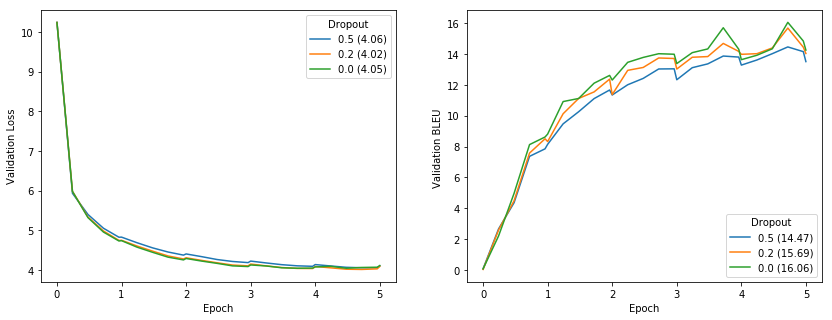

In [8]:
plot_multiple_learning_curves(experiment_results, 'enc_dropout', 'Dropout')